<h1><center>In the name of God</center></h1>

In [193]:
using  Plots, LinearAlgebra, Optim, Distributions, Roots, Random, Interpolations, Flux, Zygote, BenchmarkTools
pyplot();

# 1 Bellman Equation with Shocks

## 1.1 Solve the Bellman Equation using a Value Function Iteration Method

In [235]:
function VFIWS(r, h, β, Γ, y_star, N, IG, ξ; R=10^3, ϵ=10^-3) #Value function iteration with shocks
    G = range(10^-6, Γ(y_star)[2], N)
    V = IG.(G) #Initial Value function
    V_next = Array{Float64}(undef, N)
    U = Array{Float64}(undef, N)
    rs = rand(ξ,R)
    sup = 1
    while ~(isapprox(sup, 0.0; atol=ϵ, rtol=0))
        V0 = LinearInterpolation(G, V[:,end], extrapolation_bc=Line())
        for i in 1:N
            Vh(u) = mean(V0(h(G[i], u, rs)))
            Ω(u) = -(r(G[i],u) + β*Vh(u))
            opt = optimize(Ω, Γ(G[i])[1], Γ(G[i])[2])
            U[i] = opt.minimizer 
            V_next[i] = -Ω(U[i])
        end
        V = hcat(V,V_next)
        sup = maximum(abs.(V[:,end] .- V[:,end-1]))
    end
    P = U #Policy function
    return V, P
end

VFIWS (generic function with 1 method)

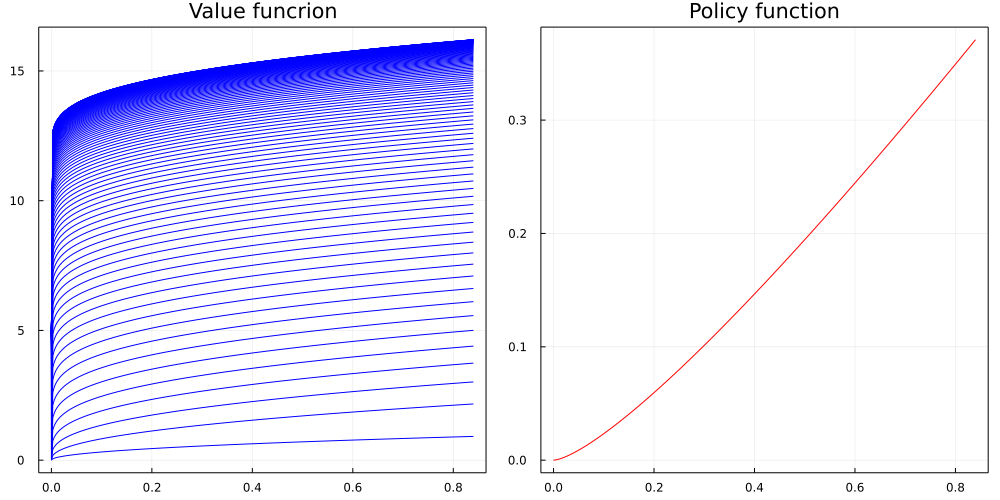

In [11]:
σ = 0.5
α = 2/3
β = 0.95
N = 300
ω = 0.05
IG(y) = √y
r(y,u) = (u .^ (1-σ)) ./ (1-σ)
Γ(y) = [10^-7, y]
h(y,u,ξ) = ξ .* ((y .- u) .^ α)
ξ = LogNormal(0, ω)
y_star = 0.84
Value_funcrion, Policy_function = VFIWS(r, h, β, Γ, y_star, N, IG, ξ)
plots = []
gr(fmt = :png, size = (1000, 500))
p1 = plot(range(10^-6, Γ(y_star)[2], N), Value_funcrion, title = "Value funcrion", label=false, c="blue")
push!(plots,p1)
p2 = plot(range(10^-6, Γ(y_star)[2], N), Policy_function, title = "Policy function", label=false, c="red")
push!(plots,p2)
plot(plots..., framestyle = :box)

## 1.2 Solve the Bellman Equation using a Policy Function Iteration Method

In [8]:
function PFIWS(r, h, β, Γ, y_star, N, IG, ξ; R=10^3, ϵ=10^-2) #Policy function iteration with shocks
    G = range(10^-6, Γ(y_star)[2], N)
    ry(y,u) = Flux.gradient(r, y, u)[1]
    ru(y,u) = Flux.gradient(r, y, u)[2]
    hy(y,u,ξ) = Flux.gradient(h, y, u, ξ)[1]
    hu(y,u,ξ) = Flux.gradient(h, y, u, ξ)[2]
    V_Prim = IG.(G)
    u_next = Array{Float64}(undef, N)
    U = Array{Float64}(undef, N)
    λ = Array{Float64}(undef, N) 
    rs = rand(ξ,R)
    sup = 1
    while ~(isapprox(sup, 0.0; atol=ϵ, rtol=0))
        λ = LinearInterpolation(G, V_Prim, extrapolation_bc=Line())
        for i in 2:N
            E1(u) = mean(hu.(G[i],u,rs) .* λ(h(G[i],u,rs)))
            E(u) = ru(G[i],u) + β*E1(u) #Euler Equation
            u_next[i] = find_zero(E, (Γ(G[i])))
        end
        u_next[1] = u_next[2]
        U = hcat(U,u_next)
        if typeof(ry(G[1],u_next[1])) == Nothing
            for i in 2:N
                E2 = mean(hy.(G[i], u_next[i], rs) .* λ(h(G[i], u_next[i], rs)))
                V_Prim[i] = β*E2   #Envelope Condition
            end
        else
            for i in 2:N
                E2 = mean(hy.(G[i], u_next[i], rs) .* λ(h(G[i], u_next[i], rs)))
                V_Prim[i] = ry(G[i],u_next[i]) + (β * E2)   #Envelope Condition
            end
        end
    V_Prim[1] = V_Prim[2]
        sup = maximum(abs.(U[:,end] .- U[:,end-1]))
    end
    return U
end

PFIWS (generic function with 1 method)

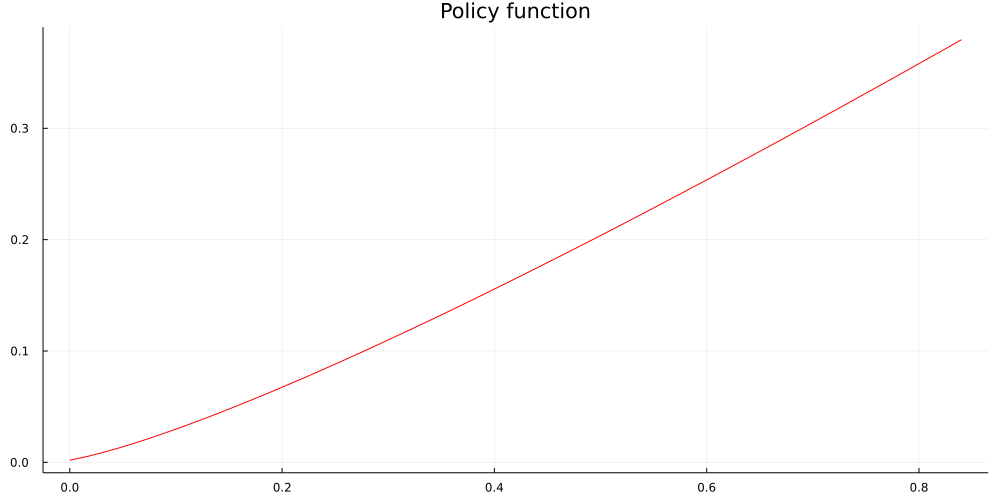

In [9]:
σ = 0.5
α = 2/3
β = 0.95
N = 50
ω = 0.05
IG(y) = √y
r(y,u) = (u ^ (1-σ)) / (1-σ)
Γ(y) = [10^-7, y]
h(y,u,ξ) = ξ .* ((y - u) ^ α)
ξ = LogNormal(0, ω)
y_star = 0.84
Policy_function = PFIWS(r, h, β, Γ, y_star, N, IG, ξ)
p2 = plot(range(10^-6, Γ(y_star)[2], N-1), Policy_function[2:end,end], title = "Policy function", label=false, c="red")

## 1.3 Write a solver class such that it can solve any bellman problem

In [194]:
function Bellman_Slover(r, h, β, Γ, y_star, N, IG, ξ, Method; R=10^3, ϵ=10^-3)
    if Method == "VI" 
        return VFIWS(r, h, β, Γ, y_star, N, IG, ξ)
    elseif Metod == "PI"
        return PFIWS(r, h, β, Γ, y_star, N, IG, ξ)
    end
end

Bellman_Slover (generic function with 1 method)

# 2 Transitional Dynamics

## 2.1 Solve that Bellman equation numerically

In [204]:
function VFI(F, β, Γ, K_star, N, IG, ; ϵ=10^-3)
    G = range(10^-6, Γ(K_star)[2], 100)
    V = IG.(G) #Initial Value function
    P = Array{Float64}(undef, N)
    V_next = Array{Float64}(undef, N)
    g = Array{Float64}(undef, N) #Policy function
    sup = 1
    while ~(isapprox(sup, 0.0; atol=ϵ, rtol=0))
        V0 = LinearInterpolation(G, V[:,end], extrapolation_bc=Line())
        for i in 1:N
            Ω(y) = -(F(G[i],y) + β*V0(y))
            opt = optimize(Ω, Γ(G[i])[1], Γ(G[i])[2])
            g[i] = opt.minimizer
            V_next[i] = -Ω(g[i])
        end
        P = hcat(P,g)
        V = hcat(V,V_next)
        sup = maximum(abs.(V[:,end] .- V[:,end-1]))
    end
    return V, P
end

VFI (generic function with 1 method)

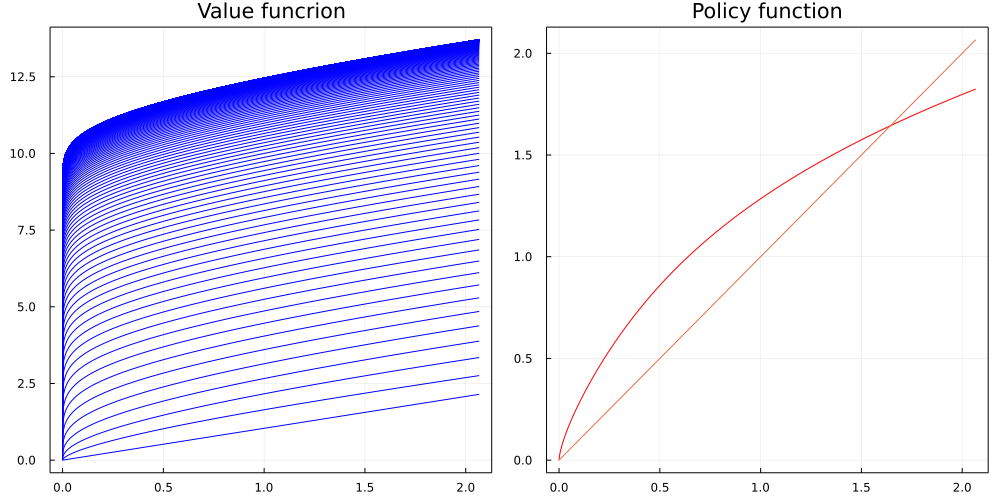

In [8]:
σ = 0.1
A = 1
α = 0.65
pk = 1
δ = 0.5
β = 0.95
N = 1000
IG(x) = x
F(x,y) = (1/(1-σ)).*((A.*x.^α .+ pk.*(1-δ).*x .- pk.*y).^(1-σ))
Γ(x) = [10^-6, (A*(x)^α)/pk + (1-δ)*x]
K_star = ((A*α)/(pk*((1/β - 1)+δ)))^(1/(1-α))
Value_funcrion, Policy_function = VFI(F, β, Γ, K_star, N, IG; ϵ=10^-5)
plots = []
gr(fmt = :png, size = (1000, 500))
p1 = plot(range(0.0, K_star*1.3, N), Value_funcrion, title = "Value funcrion", label=false, c="blue")
push!(plots,p1)
p2 = plot(range(0.0, K_star*1.3, N), Policy_function[:,end], title = "Policy function", label=false, c="red")
plot!(p2,range(0.0, K_star*1.3, N),range(0.0, K_star*1.3, N))
push!(plots,p2)
plot(plots..., framestyle = :box, legend=false)

## 2.2 Write a function to calculate the half-life time

In [81]:
function HLT(PF, k_star, k0) # Half-Life time function
    k_prim = PF(k0)
    ns = 0
    while (k_prim < 0.5*k_star)
        k = k_prim
        k_prim = PF(k)
        ns += 1
    end
    return ns
end;

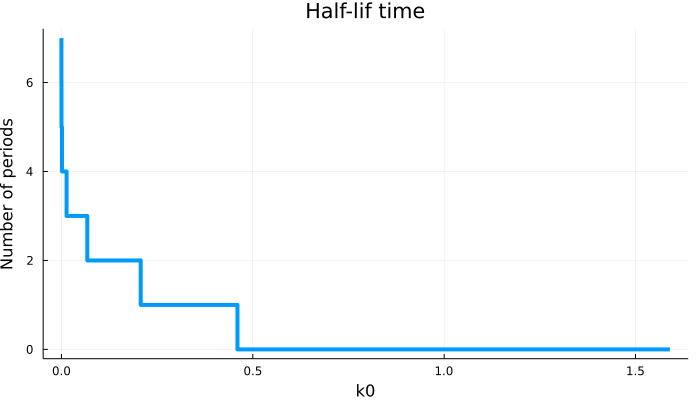

In [85]:
PF = LinearInterpolation(range(0, Γ(K_star)[2], N), Policy_function[:,end], extrapolation_bc=Line())
k_grid = range(0, K_star, 100000)
hlt = []
for k in k_grid
    append!(hlt,HLT(PF, K_star, k))
end
gr(fmt = :png, size = (700, 400))
plot(k_grid,hlt,lw = 4,title="Half-lif time", legend=false)
xlabel!("k0")
ylabel!("Number of periods")

## 2.3 Write a function to calculate the 1% distance of the steady state

In [82]:
function One_percent_LT(PF, k_star, k0) # Half-Life time function
    k_prim = PF(k0)
    ns = 0
    while (k_prim < 0.99*k_star)
        k = k_prim
        k_prim = PF(k)
        ns += 1
    end
    return ns
end;

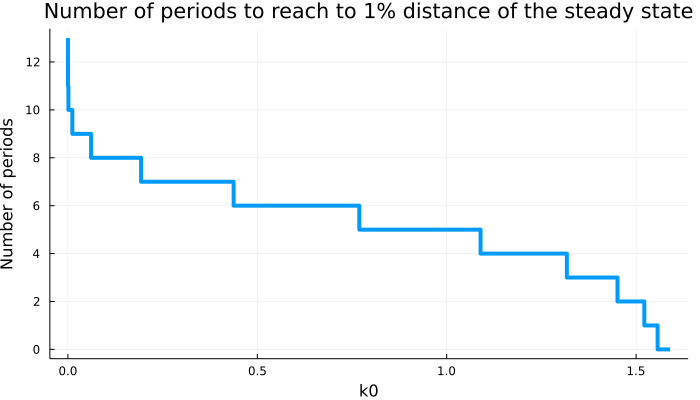

In [86]:
olt = []
for k in k_grid
    append!(olt,One_percent_LT(PF, K_star, k))
end
gr(fmt = :png, size = (700, 400))
plot(k_grid,olt,lw = 4,title="Number of periods to reach to 1% distance of the steady state", legend=false)
xlabel!("k0")
ylabel!("Number of periods")

# 3 Log-Linearization Method

## 3.1

in this part we want to solve the following Bellman Equation using Log-Linearinzation Method.
we assume that $log \ \xi$ is $N(0,\omega)$

$$
V(y)=\max_{c}\left\{\frac{c^{1-\sigma}}{1-\sigma}+\beta \ E[V(\xi(y-c)^{\alpha})]\right\} 
$$

in this problem we can find that:
$$
y-c = k' - (1-\delta)k
$$
$$
y -c  = k'
$$
$$
\Rightarrow \boxed{\delta = 1 }
$$

now, we can rewrite the problem as below:

$$
V(k)=\max_{k'}\left\{\frac{(\xi k^{\alpha} - k')^{1-\delta}}{1- \delta}+\beta E[ V\left(k'\right)]\right\} 
$$

subject to constraints we can write F.O.C conditions as below:
$$
    [k'] : \left(\xi k^{\alpha} - k' \right)^{-\sigma} = \beta E[ V'\left(k'\right)]   
$$
$$    
    [k] \ : V'(k) = \alpha \xi k^{\alpha - 1} \left(\xi k^{\alpha} - k' \right)^{-\sigma} 
$$

in steady state we know that $\ k  =  k'$. so we can solve the problem in steady state as below:

$$
\left(\xi k^{\alpha} - k \right)^{-\sigma} = \beta E \left[\alpha \xi k^{\alpha - 1}(\xi k^{\alpha} - k')^{-\sigma} \right] 
$$
as mentioned in the question we know that
$$
\log{\xi} : N(0, \ w)
$$
so:
$$
\Rightarrow E(\xi) = 1 
$$
then we can find $k$ in steady state:
$$
\boxed{k_{ss} = \left(\beta \alpha \right)^{\frac{1}{1-\alpha}}}
$$

Now we can log-linearize the problem with difrantiation methos as below:
$$
-\sigma(\xi k^{\alpha} - k)^{-\sigma -1}(\xi \alpha k^{\alpha - 1} dk - dk) = 
\beta \alpha (\alpha -1) k^{\alpha - 2} dk (k^{\alpha} - k)^{-\sigma} - \sigma \beta \alpha k^{\alpha - 1}(k^{\alpha}-k)^{-\sigma -1}(\alpha k^{\alpha - 1} dk - dk)
$$

Now we can log-linearize the problem with difrantiation methos as below:
$$
-\sigma(\xi k^{\alpha} - k)^{-\sigma -1}(\xi \alpha k^{\alpha - 1} dk - dk) = 
\beta \alpha (\alpha -1) k^{\alpha - 2} dk (k^{\alpha} - k)^{-\sigma} - \sigma \beta \alpha k^{\alpha - 1}(k^{\alpha}-k)^{-\sigma -1}(\alpha k^{\alpha - 1} dk - dk)
$$

now we can define $\frac{d k}{k} = \hat k$ and we know that $\bar E = E(\xi) = 1$ and $k_{ss} = (\beta \alpha)^{\frac{1}{1-\alpha}}$ and solve the bellman as below:

$$
- \sigma (k^{\alpha} - k)^{-\sigma -1} (\alpha k^{\alpha} \hat k - k\hat k) - \sigma (\xi k^{\alpha} -k )^{-\sigma -1} (k^{\alpha }d\xi) = \beta \alpha (\alpha - 1) k^{\alpha - 1} \hat k ( k^{\alpha} - k )^{-\sigma} - \sigma \beta \alpha k^{\alpha -1} (k^{\alpha} - k)^{-\sigma -1} (\alpha k^{\alpha }\hat k - k \hat k)
$$

$$
\Rightarrow  -\sigma (k^{\alpha} - k)^{-1} (\alpha k^{\alpha }\hat k - k \hat k) = (\alpha -1) \hat k - \sigma (k^{\alpha} - k) (\alpha k^{\alpha }\hat k - k \hat k) + (\sigma) (k^{\alpha} - k)^{-1} k^{\alpha} \hat{\xi}
$$

$$
\Rightarrow \hat{k_t} = \frac{\sigma \bar{k^\alpha}}{(\alpha -1)(\bar{k^\alpha }- \bar{k})} \hat{\xi_t}
$$
$$
\bar k = (\beta \alpha)^{\frac{1}{1-\alpha}}
$$
$$
\Rightarrow \boxed{\hat{k_t} = \frac{\sigma}{(1 - \alpha)(1-\beta \alpha)} \hat{\xi_t}}
$$

## 3.2

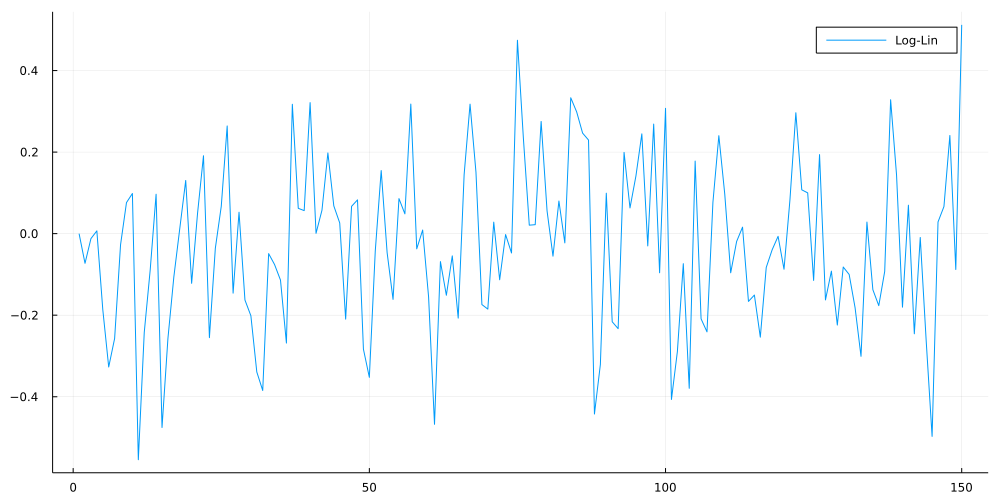

In [247]:
σ = 0.5
α = 2/3
β = 0.95
ω = 0.05
R = 300
ξ_shock=rand(LogNormal(0,ω),R)
ξ_shock_detrend=log.(ξ_shock).-log(mean(LogNormal(0,ω)))
k_hat_0 = 0.0
k = zeros(R)
k[1] = k_hat_0
for i = 1:R-1
    k[i+1]=(β*α)^(1/(1-α))*k[i]+(σ/((1-α)*(1-β*α)))*ξ_shock_detrend[i]
end
plot(k[1:150], label="Log-Lin")

## 3.3

in this part we want to solve the following Bellman Equation using Log-Linearinzation Method like part 1.
we assume that $log \ s' = \rho \ log \ s + \epsilon$ and $\epsilon$ is $N(0,\omega)$

$$
V(k,s) = \max_{k,s} {\frac{(s k^\alpha + (1-\sigma)k - k')^{1-\sigma}}{1-\sigma} + \beta E[V(k',s')|s]}
$$

as we done in part 1 we can find F.O.C conditions.
in this part we have:
$$
[k] : V' = \frac{\left(1-\sigma \right) \left(\alpha k^{\alpha - 1} S + \left(1-\delta \right) \right) (Sk^{\alpha} + (1-\delta)k - k')^{-\sigma}}{1-\sigma}
$$
$$
[k'] : \frac{\left(1-\sigma \right) (+1) (Sk^{\alpha} + (1-\delta)k - k')^{-\sigma}}{1-\sigma} = \beta E(V')
$$

so we can write:
$$
(Sk^{\alpha} + (1-\delta)k - k')^{-\sigma} = \beta E \left( (\alpha k^{\alpha - 1} S + (1-\delta)) (Sk^{\alpha} + (1-\delta)k - k')^{-\sigma} \right)
$$

now we can calculate steady state:
$$
(k^{\alpha} -\delta k)^{-\sigma} =  \beta \left( (\alpha k^{\alpha - 1} + (1-\delta)) (k^{\alpha} -\delta k)^{-\sigma} \right)
$$
$$
\Rightarrow \bar{k} = \left( \left( \frac{1}{\beta} - \left(1-\delta \right) \right) \frac{1}{\alpha}\right)^{\frac{1}{1-\alpha}}
$$
$$
\Rightarrow \boxed{\bar{k} = \left( \frac{\alpha}{\rho + \delta} \right)^{\frac{1}{1-\alpha}}}
$$

Now we can log-linearize the problem with difrantiation methos as below:
$$
(-\sigma)(k^{\alpha} -\delta k)^{-\sigma} (k^{\alpha} ds - \delta dk) = 
\beta \left[ \left( \alpha (\alpha -1) k^{\alpha -2}dk \right) (k^{\alpha} - \delta k)^{-\sigma} - \sigma (k^{\alpha} - \delta k)^{-\sigma -1}(\alpha k^{\alpha -1} dk - \delta dk) \right]
$$

$$
\Rightarrow (-\sigma) \left(k^{\alpha} \hat{s} - \delta k \hat{k} \right) = 
\left[ \frac{\alpha (\alpha - 1) k^{\alpha -1}}{\alpha k^{\alpha -1} + 1 - \delta} \hat{k} - \left( \frac{\sigma}{k^{\alpha} - \delta k} \right) 
\left( \frac{\alpha k^{\alpha} \hat{k} - \delta k \hat{k}}{\alpha k^{\alpha - 1} + 1 - \delta } \right) \right]
$$

$$
\Rightarrow \hat{S}_t = \left( \frac{\alpha (1-\alpha)}{\sigma \left( \alpha k^{2\alpha -1} + (1-\delta)k^{\alpha} \right)} + \frac{1}{k^{\alpha} - \delta k}. \frac{\alpha k^{\alpha} - \delta k}{\alpha k^{2\alpha -1} + (1-\delta)k^{\alpha}} + \delta k^{1-\alpha} \right) \hat{K}_t \\ 
k = \bar{k} = \left( \frac{\alpha}{\rho + \delta} \right)^{\frac{1}{1-\alpha}}
$$

$$
\boxed{\hat{S}_t = \left[ \frac{\alpha (1-\alpha)}{\sigma} + \frac{\alpha \bar{k}^{\alpha} - \delta \bar{k}}{\bar{k}^{\alpha} - \delta \bar{k}} + \delta \left( \alpha \bar{k}^{\alpha} + (1-\delta)\bar{k} \right) \right] \hat{K}_t}
$$
$$
that: \bar{k} = \left( \frac{\alpha}{\rho + \delta} \right)^{\frac{1}{1-\alpha}}
$$

# 4 Discrete Dynamic Programming

## 4.1

In [98]:
function DDP(R, Q, Grid, IG, β) # with shocks and without shocks
    ns = size(R)[1] # number of shocks
    gs = size(R)[2] # grid size
    sup = 1
    One = ones(gs) # 1 vector
    V = repeat(IG.(range(Grid[1], Grid[2], gs)), 1, ns)' # Value function matrix (Initial guess)
    g = zeros(ns,gs)
    gp = ones(ns,gs)
    while ~(isapprox(sup, 0.0; atol=0, rtol=0))
        for i in 1:ns # T_operator for V1 to Vns
            V[i,:], Argmax = findmax(R[i,:,:] .+ sum([β*Q[i,j]*One*V[j,:]' for j in 1:ns]), dims=2)
            for a in 1:gs
                g[i,a] = Argmax[a][2] # Policy function
            end
        end
        sup = sum((gp .- g).^2)
        gp = copy(g)
    end
    P = zeros(ns,gs)
    for i in 1:ns
        for j in 1:gs
            P[i,j] = Grid[Int(g[i,j])]
        end
    end
    return V, P
end

DDP (generic function with 1 method)

In [99]:
function return_function(r, σ, w, S, Grid)
    ns = length(S)
    gs = length(Grid)
    R = zeros(ns, gs, gs)
    Rr(a,s,a_prim) = (((1+r)*a + w*s - a_prim)^(1-σ)) / (1-σ)
    for i in 1:ns
        for j in 1:gs
            for k in 1:gs
                R[i,j,k] = ((1+r)*Grid[j] + w*S[i] - Grid[k])>0 ? Rr(Grid[j],S[i],Grid[k]) : -100000
            end
        end
    end
    return R
end

return_function (generic function with 1 method)

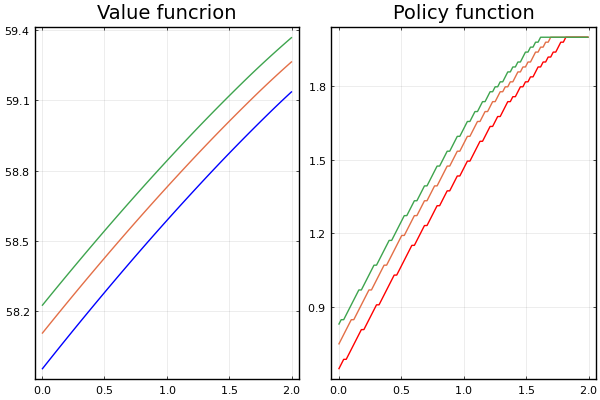

In [30]:
# with shocks
σ = 0.8
w = 1
β = 0.95
N = 100
ω = 0.05
r = 0.15
ns = 100
Grid = range(0, 2, N)
S = rand(LogNormal(1,0.02),ns)
R = return_function(r, σ, w, S, Grid)
Q = ones(ns,ns)./ns
IG(x) = √x
Value_function, Policy_function = DDP(R, Q, Grid, IG, β);
plots = []
p1 = plot(Grid, Value_function[1,:], title = "Value funcrion", label=false, c="blue")
plot!(p1, Grid, Value_function[2,:])
plot!(p1, Grid, Value_function[3,:])
push!(plots,p1)
p2 = plot(Grid, Policy_function[1,:], title = "Policy function", label=false, c="red")
plot!(p2, Grid, Policy_function[2,:])
plot!(p2, Grid, Policy_function[3,:])
push!(plots,p2)
plot(plots..., framestyle = :box, legend=false)

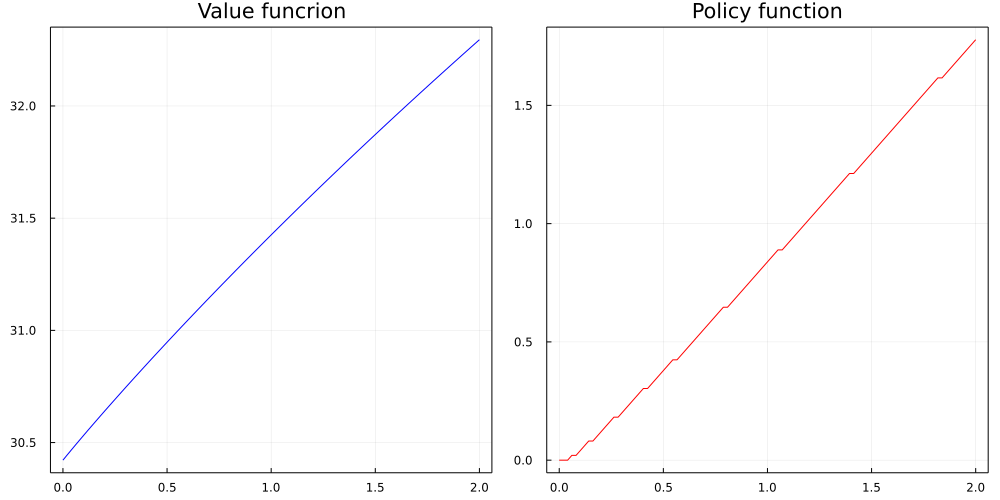

In [178]:
# without shocks
σ = 0.8
w = 1
β = 0.85
N = 100
r = 0.15
Grid = range(0, 2, N)
S =[1]
R = return_function(r, σ, w, S, Grid)
Q = [1]
IG(x) = √x
Value_function, Policy_function = DDP(R, Q, Grid, IG, β);
gr(fmt = :png, size = (1000, 500))
plots = []
p1 = plot(Grid, Value_function[1,:], title = "Value funcrion", label=false, c="blue")
push!(plots,p1)
p2 = plot(Grid, Policy_function[1,:], title = "Policy function", label=false, c="red")
push!(plots,p2)
plot(plots..., framestyle = :box, legend=false)

## 4.2

**For comparing the results of two methods, we use DDP without shocks, because DDP with shocks has several Value and Policy function and we don't know how to compare this with continuous maximization method that has one Value and Policy function**

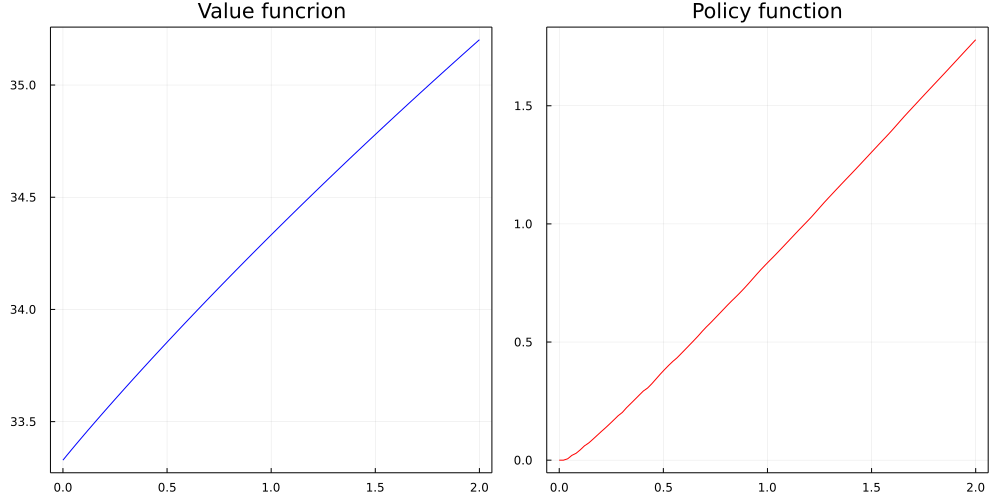

In [190]:
# without shocks
σ = 0.8
w = 1
β = 0.85
N = 100
r = 0.15
IG(x) = √x
F(x,y) = (((1+r)*x + w - y)^(1-σ)) / (1-σ)
Γ(x) = [10^-6, (1+r)*x + w]
K_star = 2
Value_funcrion, Policy_function = VFI(F, β, Γ, K_star, N, IG; ϵ=10^-3)
plots = []
gr(fmt = :png, size = (1000, 500))
p1 = plot(range(0.0, K_star, N), Value_funcrion[:,end], title = "Value funcrion", label=false, c="blue")
push!(plots,p1)
p2 = plot(range(0.0, K_star, N), Policy_function[:,end], title = "Policy function", label=false, c="red")
push!(plots,p2)
plot(plots..., framestyle = :box, legend=false)

In [207]:
println("Value function iteration with continuous maximization method run_time:")
@btime VFI(F, β, Γ, K_star, N, IG);
println("and Discrete dynamic programming method run_time:")
@btime DDP(R, Q, Grid, IG, β);
println("So Discrete dynamic programming method is faster than Value function iteration with continuous maximization method")

Value function iteration with continuous maximization method run_time:
  233.926 ms (6032766 allocations: 109.29 MiB)
and Discrete dynamic programming method run_time:
  1.266 ms (3404 allocations: 3.61 MiB)
So Discrete dynamic programming method is faster than Value function iteration with continuous maximization method


## 4.3

In [216]:
function VFI_with_DDP_Initial_Guess(F, β, Γ, K_star; ϵ=10^-3)
    N = 100
    σ = 0.8
    w = 1
    r = 0.15
    G  = range(0, 2, N)
    Grid = G
    S =[1]
    Q = [1]
    R = return_function(r, σ, w, S, Grid)
    IG(x) = √x
    V = DDP(R, Q, Grid, IG, β)[1]' #Initial Value function
    P = Array{Float64}(undef, N)
    V_next = Array{Float64}(undef, N)
    g = Array{Float64}(undef, N) #Policy function
    sup = 1
    while ~(isapprox(sup, 0.0; atol=ϵ, rtol=0))
        V0 = LinearInterpolation(G, V[:,end], extrapolation_bc=Line())
        for i in 1:N
            Ω(y) = -(F(G[i],y) + β*V0(y))
            opt = optimize(Ω, Γ(G[i])[1], Γ(G[i])[2])
            g[i] = opt.minimizer
            V_next[i] = -Ω(g[i])
        end
        P = hcat(P,g)
        V = hcat(V,V_next)
        sup = maximum(abs.(V[:,end] .- V[:,end-1]))
    end
    return V, P
end

VFI_with_DDP_Initial_Guess (generic function with 2 methods)

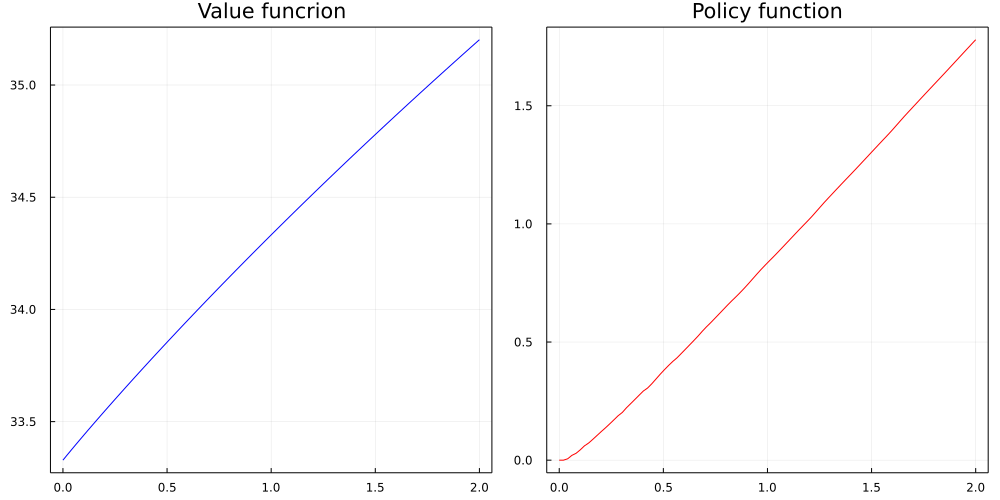

In [217]:
σ = 0.8
w = 1
β = 0.85
N = 100
r = 0.15
IG(x) = √x
F(x,y) = (((1+r)*x + w - y)^(1-σ)) / (1-σ)
Γ(x) = [10^-6, (1+r)*x + w]
K_star = 2
Value_funcrion, Policy_function = VFI_with_DDP_Initial_Guess(F, β, Γ, K_star; ϵ=10^-3)
plots = []
gr(fmt = :png, size = (1000, 500))
p1 = plot(range(0.0, K_star, N), Value_funcrion[:,end], title = "Value funcrion", label=false, c="blue")
push!(plots,p1)
p2 = plot(range(0.0, K_star, N), Policy_function[:,end], title = "Policy function", label=false, c="red")
push!(plots,p2)
plot(plots..., framestyle = :box, legend=false)

In [220]:
println("Value function iteration with continuous maximization method with initial guess from DDP run_time:")
@btime VFI_with_DDP_Initial_Guess(F, β, Γ, K_star; ϵ=10^-3);

Value function iteration with continuous maximization method with initial guess from DDP run_time:
  152.204 ms (4463265 allocations: 84.02 MiB)


** **Final report about runtime:** **
  
| No. | Method | Runtime |
| --- | --- | --- |
| 1 | Discrete dynamic programming  | **1.266 ms** |
| 2 | Value function iteration with continuous maximization with initial guess from DDP| **152.204 ms** |
| 3 | Value function iteration with continuous maximization| **233.926 ms** |